Dataset shape: (300, 6)
Price statistics:
count       300.000000
mean     466593.202081
std       84702.930890
min      268393.476826
25%      407993.194971
50%      465824.348111
75%      522122.921266
max      746976.589916
Name: price_usd, dtype: float64


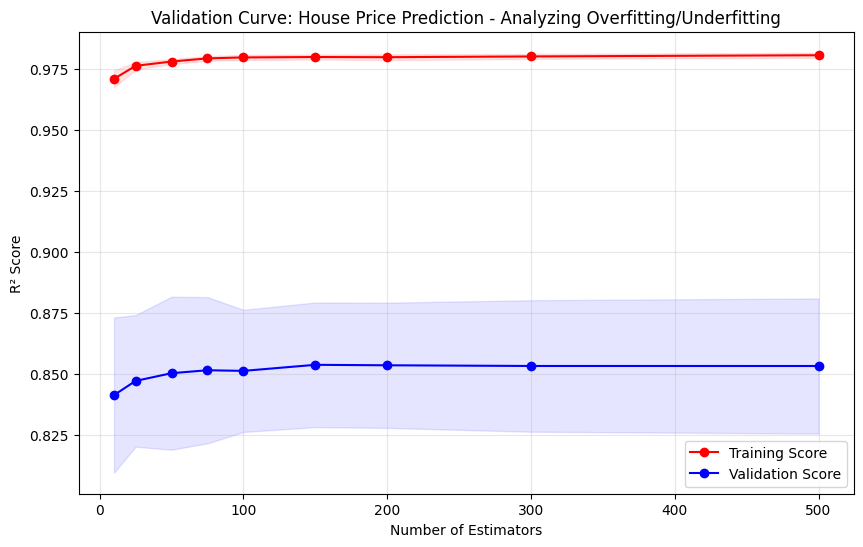


Validation Curve Analysis:
n_estimators= 10: Train R²=0.971, Validation R²=0.841, Gap=0.130 -> Overfitting
n_estimators= 25: Train R²=0.976, Validation R²=0.847, Gap=0.129 -> Overfitting
n_estimators= 50: Train R²=0.978, Validation R²=0.850, Gap=0.128 -> Overfitting
n_estimators= 75: Train R²=0.979, Validation R²=0.852, Gap=0.128 -> Overfitting
n_estimators=100: Train R²=0.980, Validation R²=0.851, Gap=0.128 -> Overfitting
n_estimators=150: Train R²=0.980, Validation R²=0.854, Gap=0.126 -> Overfitting
n_estimators=200: Train R²=0.980, Validation R²=0.854, Gap=0.126 -> Overfitting
n_estimators=300: Train R²=0.980, Validation R²=0.853, Gap=0.127 -> Overfitting
n_estimators=500: Train R²=0.981, Validation R²=0.853, Gap=0.127 -> Overfitting

Optimal number of estimators: 150

Final Model Performance:
Mean Absolute Error: $24,750.20
Root Mean Square Error: $30,557.79
R² Score: 0.841

Feature Importance:
size_sqft      : 0.752
age_years      : 0.150
location_score : 0.073
num_bedrooms   : 0

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Generate synthetic house price dataset
np.random.seed(42)
n_samples = 300

# Generate features
size_sqft = np.random.normal(2000, 500, n_samples)
size_sqft = np.clip(size_sqft, 800, 4000)  # Reasonable house sizes

num_bedrooms = np.random.choice([2, 3, 4, 5], n_samples, p=[0.2, 0.4, 0.3, 0.1])
num_bathrooms = np.random.choice([1, 2, 3, 4], n_samples, p=[0.1, 0.5, 0.3, 0.1])
age_years = np.random.uniform(0, 50, n_samples)
location_score = np.random.uniform(1, 10, n_samples)

# Create target variable with realistic relationships
base_price = (
    size_sqft * 150 +  # $150 per sqft
    num_bedrooms * 15000 +  # $15k per bedroom
    num_bathrooms * 10000 +  # $10k per bathroom
    (50 - age_years) * 2000 +  # Newer houses worth more
    location_score * 8000  # Location premium
)

# Add some noise
price_usd = base_price + np.random.normal(0, 25000, n_samples)
price_usd = np.clip(price_usd, 100000, 800000)  # Reasonable price range

# Create DataFrame
data = pd.DataFrame({
    'size_sqft': size_sqft,
    'num_bedrooms': num_bedrooms,
    'num_bathrooms': num_bathrooms,
    'age_years': age_years,
    'location_score': location_score,
    'price_usd': price_usd
})

print("Dataset shape:", data.shape)
print("Price statistics:")
print(data['price_usd'].describe())

# Split data
X = data.drop('price_usd', axis=1)
y = data['price_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Generate validation curves to analyze overfitting/underfitting
param_range = [10, 25, 50, 75, 100, 150, 200, 300, 500]

# Use RandomForestRegressor for regression problem with appropriate scoring
train_scores, test_scores = validation_curve(
    RandomForestRegressor(random_state=42),
    X, y, param_name='n_estimators', param_range=param_range,
    cv=5, scoring='r2'  # Use R² for regression
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Plot validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_scores_mean, 'o-', color='red', label='Training Score')
plt.plot(param_range, test_scores_mean, 'o-', color='blue', label='Validation Score')

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='red')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='blue')

plt.xlabel('Number of Estimators')
plt.ylabel('R² Score')
plt.title('Validation Curve: House Price Prediction - Analyzing Overfitting/Underfitting')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Analyze results with appropriate thresholds for regression
print("\nValidation Curve Analysis:")
print("=" * 50)
for i, n_est in enumerate(param_range):
    gap = train_scores_mean[i] - test_scores_mean[i]
    if gap > 0.1:  # Large gap indicates overfitting
        status = "Overfitting"
    elif test_scores_mean[i] < 0.7:  # Low R² indicates underfitting
        status = "Underfitting"
    else:
        status = "Good Fit"
    
    print(f"n_estimators={n_est:3d}: Train R²={train_scores_mean[i]:.3f}, "
          f"Validation R²={test_scores_mean[i]:.3f}, Gap={gap:.3f} -> {status}")

# Train final model with optimal parameters and evaluate
optimal_n_estimators = param_range[np.argmax(test_scores_mean)]
print(f"\nOptimal number of estimators: {optimal_n_estimators}")

final_model = RandomForestRegressor(n_estimators=optimal_n_estimators, random_state=42)
final_model.fit(X_train, y_train)

# Make predictions
y_pred = final_model.predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nFinal Model Performance:")
print("=" * 30)
print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"Root Mean Square Error: ${rmse:,.2f}")
print(f"R² Score: {r2:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFeature Importance:")
print("=" * 25)
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']:15s}: {row['importance']:.3f}")

<h1>Mitigate Overfitting </h1>

Dataset shape: (2000, 6)
Price statistics:
count      2000.000000
mean     471804.015935
std       87424.777014
min      212860.843521
25%      412989.651034
50%      472105.306315
75%      529269.568415
max      758605.095869
Name: price_usd, dtype: float64


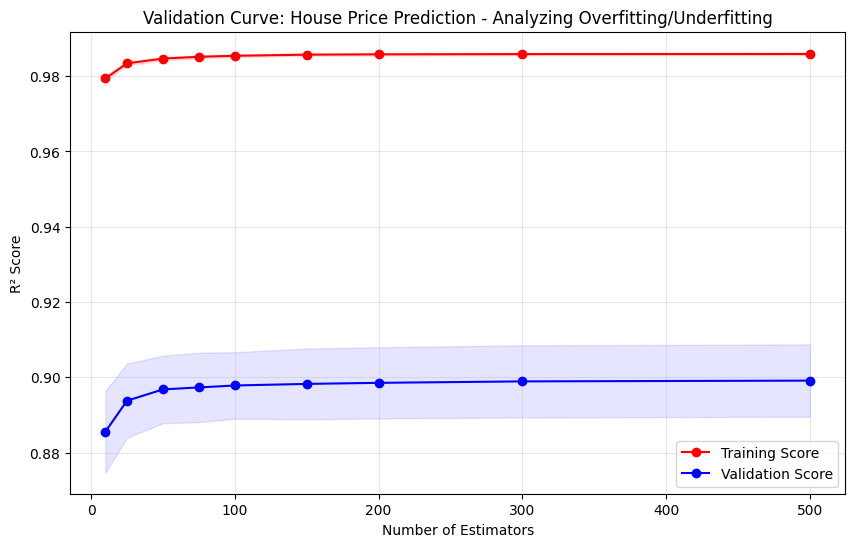


Validation Curve Analysis:
n_estimators= 10: Train R²=0.979, Validation R²=0.886, Gap=0.094 -> Good Fit
n_estimators= 25: Train R²=0.983, Validation R²=0.894, Gap=0.090 -> Good Fit
n_estimators= 50: Train R²=0.985, Validation R²=0.897, Gap=0.088 -> Good Fit
n_estimators= 75: Train R²=0.985, Validation R²=0.897, Gap=0.088 -> Good Fit
n_estimators=100: Train R²=0.985, Validation R²=0.898, Gap=0.088 -> Good Fit
n_estimators=150: Train R²=0.986, Validation R²=0.898, Gap=0.087 -> Good Fit
n_estimators=200: Train R²=0.986, Validation R²=0.899, Gap=0.087 -> Good Fit
n_estimators=300: Train R²=0.986, Validation R²=0.899, Gap=0.087 -> Good Fit
n_estimators=500: Train R²=0.986, Validation R²=0.899, Gap=0.087 -> Good Fit

Optimal number of estimators: 500

Final Model Performance:
Mean Absolute Error: $21,224.86
Root Mean Square Error: $26,787.26
R² Score: 0.906

Feature Importance:
size_sqft      : 0.772
age_years      : 0.128
location_score : 0.071
num_bedrooms   : 0.018
num_bathrooms  : 0.011

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Generate synthetic house price dataset
np.random.seed(42)
n_samples = 2000

# Generate features
size_sqft = np.random.normal(2000, 500, n_samples)
size_sqft = np.clip(size_sqft, 800, 4000)  # Reasonable house sizes

num_bedrooms = np.random.choice([2, 3, 4, 5], n_samples, p=[0.2, 0.4, 0.3, 0.1])
num_bathrooms = np.random.choice([1, 2, 3, 4], n_samples, p=[0.1, 0.5, 0.3, 0.1])
age_years = np.random.uniform(0, 50, n_samples)
location_score = np.random.uniform(1, 10, n_samples)

# Create target variable with realistic relationships
base_price = (
    size_sqft * 150 +  # $150 per sqft
    num_bedrooms * 15000 +  # $15k per bedroom
    num_bathrooms * 10000 +  # $10k per bathroom
    (50 - age_years) * 2000 +  # Newer houses worth more
    location_score * 8000  # Location premium
)

# Add some noise
price_usd = base_price + np.random.normal(0, 25000, n_samples)
price_usd = np.clip(price_usd, 100000, 800000)  # Reasonable price range

# Create DataFrame
data = pd.DataFrame({
    'size_sqft': size_sqft,
    'num_bedrooms': num_bedrooms,
    'num_bathrooms': num_bathrooms,
    'age_years': age_years,
    'location_score': location_score,
    'price_usd': price_usd
})

print("Dataset shape:", data.shape)
print("Price statistics:")
print(data['price_usd'].describe())

# Split data
X = data.drop('price_usd', axis=1)
y = data['price_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Generate validation curves to analyze overfitting/underfitting
param_range = [10, 25, 50, 75, 100, 150, 200, 300, 500]

# Use RandomForestRegressor for regression problem with appropriate scoring
train_scores, test_scores = validation_curve(
    RandomForestRegressor(random_state=42),
    X, y, param_name='n_estimators', param_range=param_range,
    cv=5, scoring='r2'  # Use R² for regression
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Plot validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_scores_mean, 'o-', color='red', label='Training Score')
plt.plot(param_range, test_scores_mean, 'o-', color='blue', label='Validation Score')

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='red')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='blue')

plt.xlabel('Number of Estimators')
plt.ylabel('R² Score')
plt.title('Validation Curve: House Price Prediction - Analyzing Overfitting/Underfitting')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Analyze results with appropriate thresholds for regression
print("\nValidation Curve Analysis:")
print("=" * 50)
for i, n_est in enumerate(param_range):
    gap = train_scores_mean[i] - test_scores_mean[i]
    if gap > 0.1:  # Large gap indicates overfitting
        status = "Overfitting"
    elif test_scores_mean[i] < 0.7:  # Low R² indicates underfitting
        status = "Underfitting"
    else:
        status = "Good Fit"
    
    print(f"n_estimators={n_est:3d}: Train R²={train_scores_mean[i]:.3f}, "
          f"Validation R²={test_scores_mean[i]:.3f}, Gap={gap:.3f} -> {status}")

# Train final model with optimal parameters and evaluate
optimal_n_estimators = param_range[np.argmax(test_scores_mean)]
print(f"\nOptimal number of estimators: {optimal_n_estimators}")

final_model = RandomForestRegressor(n_estimators=optimal_n_estimators, random_state=42)
final_model.fit(X_train, y_train)

# Make predictions
y_pred = final_model.predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f"\nFinal Model Performance:")
print("=" * 30)
print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"Root Mean Square Error: ${rmse:,.2f}")
print(f"R² Score: {r2:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFeature Importance:")
print("=" * 25)
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']:15s}: {row['importance']:.3f}")

<h1>Model Fine Tuning (Hyper-parameter tuning) with Grid Search Algorithm</h1>

Dataset shape: (3000, 6)
Price statistics:
count      3000.000000
mean     469514.664897
std       85672.544915
min      211815.972417
25%      409658.061360
50%      468933.653633
75%      527952.964961
max      741442.730408
Name: price_usd, dtype: float64

Performing Grid Search with 162 combinations...

Best parameters found: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation R² score: 0.881

Overfitting Analysis:
Training R²: 0.938
Test R²: 0.879
Gap: 0.059
Status: ✓ Good - Minimal Overfitting

Final Model Performance:
Mean Absolute Error: $22,795.39
Root Mean Square Error: $29,275.89
R² Score: 0.879

Feature Importance:
size_sqft      : 0.736
age_years      : 0.142
location_score : 0.086
num_bedrooms   : 0.025
num_bathrooms  : 0.010

Generating learning curve...


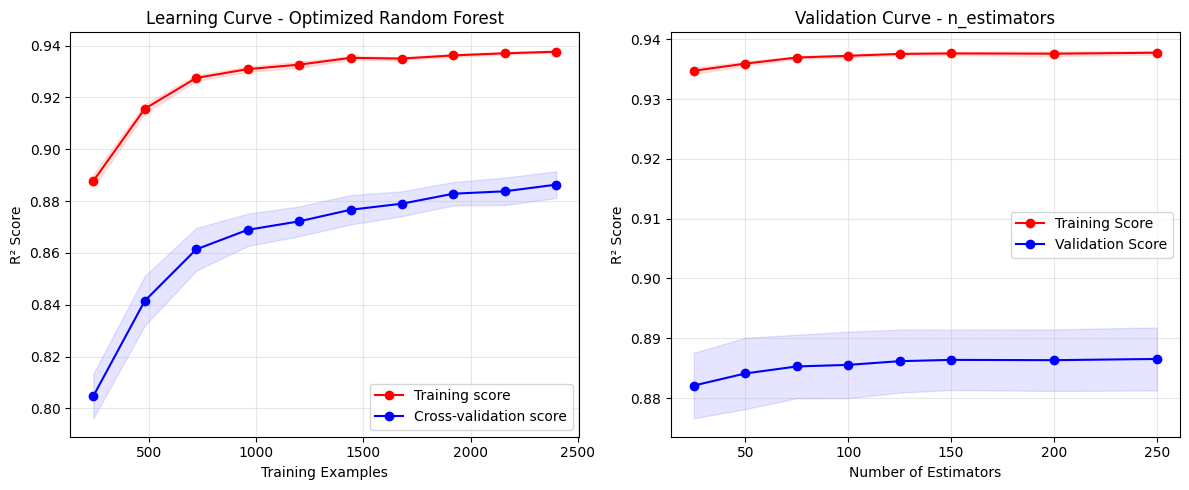


Validation Curve Analysis:
n_estimators= 10: Train R²=0.888, Validation R²=0.805, Gap=0.083 -> Good Fit
n_estimators= 25: Train R²=0.916, Validation R²=0.841, Gap=0.074 -> Good Fit
n_estimators= 50: Train R²=0.927, Validation R²=0.861, Gap=0.066 -> Good Fit
n_estimators= 75: Train R²=0.931, Validation R²=0.869, Gap=0.062 -> Good Fit
n_estimators=100: Train R²=0.933, Validation R²=0.872, Gap=0.060 -> Good Fit
n_estimators=150: Train R²=0.935, Validation R²=0.877, Gap=0.059 -> Good Fit
n_estimators=200: Train R²=0.935, Validation R²=0.879, Gap=0.056 -> Good Fit
n_estimators=300: Train R²=0.936, Validation R²=0.883, Gap=0.053 -> Good Fit
n_estimators=500: Train R²=0.937, Validation R²=0.884, Gap=0.053 -> Good Fit

Baseline Performance (predicting mean):
Mean Absolute Error: $67,579.52
Root Mean Square Error: $84,198.38
R² Score: -0.001

Improvement over baseline:
MAE improvement: 66.3%
RMSE improvement: 65.2%
R² improvement: 88.0 percentage points

Model Summary & Recommendations:
• Mode

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve, learning_curve, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Generate synthetic house price dataset
np.random.seed(42)
n_samples = 3000

# Generate features
size_sqft = np.random.normal(2000, 500, n_samples)
size_sqft = np.clip(size_sqft, 800, 4000)

num_bedrooms = np.random.choice([2, 3, 4, 5], n_samples, p=[0.2, 0.4, 0.3, 0.1])
num_bathrooms = np.random.choice([1, 2, 3, 4], n_samples, p=[0.1, 0.5, 0.3, 0.1])
age_years = np.random.uniform(0, 50, n_samples)
location_score = np.random.uniform(1, 10, n_samples)

# Create target variable with realistic relationships
base_price = (
    size_sqft * 150 +
    num_bedrooms * 15000 +
    num_bathrooms * 10000 +
    (50 - age_years) * 2000 +
    location_score * 8000
)

# Add some noise
price_usd = base_price + np.random.normal(0, 25000, n_samples)
price_usd = np.clip(price_usd, 100000, 800000)

# Create DataFrame
data = pd.DataFrame({
    'size_sqft': size_sqft,
    'num_bedrooms': num_bedrooms,
    'num_bathrooms': num_bathrooms,
    'age_years': age_years,
    'location_score': location_score,
    'price_usd': price_usd
})

print("Dataset shape:", data.shape)
print("Price statistics:")
print(data['price_usd'].describe())

# Split data
X = data.drop('price_usd', axis=1)
y = data['price_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Adjusted parameter grid to reduce overfitting (Grid Search Algorithm)
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [8, 10, 12],  # Restrict depth
    'min_samples_split': [10, 15, 20],  # Larger split requirement
    'min_samples_leaf': [4, 6, 8],  # Larger leaf requirement
    'max_features': ['sqrt', 'log2']  # Force randomness
}

print(f"\nPerforming Grid Search with {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['max_features'])} combinations...")

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"\nBest parameters found: {best_params}")
print(f"Best cross-validation R² score: {grid_search.best_score_:.3f}")

# Train final model with new parameters
final_model = grid_search.best_estimator_

# Evaluate
train_pred = final_model.predict(X_train)
train_r2 = r2_score(y_train, train_pred)

y_pred = final_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
gap = train_r2 - test_r2

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nOverfitting Analysis:")
print("=" * 25)
print(f"Training R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Gap: {gap:.3f}")

if gap <= 0.05:
    overfitting_status = "✓ Excellent - No Overfitting"
elif gap <= 0.08:
    overfitting_status = "✓ Good - Minimal Overfitting"
elif gap <= 0.12:
    overfitting_status = "⚠ Moderate Overfitting"
else:
    overfitting_status = "✗ High Overfitting"

print(f"Status: {overfitting_status}")

print(f"\nFinal Model Performance:")
print("=" * 30)
print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"Root Mean Square Error: ${rmse:,.2f}")
print(f"R² Score: {test_r2:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFeature Importance:")
print("=" * 25)
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']:15s}: {row['importance']:.3f}")

# Learning curve to visualize overfitting across different training sizes
print(f"\nGenerating learning curve...")
train_sizes, train_scores_lc, test_scores_lc = learning_curve(
    final_model, X, y, cv=5, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='r2', n_jobs=-1
)

train_scores_mean = np.mean(train_scores_lc, axis=1)
train_scores_std = np.std(train_scores_lc, axis=1)
test_scores_mean = np.mean(test_scores_lc, axis=1)
test_scores_std = np.std(test_scores_lc, axis=1)

# Plot learning curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_scores_mean, 'o-', color='red', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='blue', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='red')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='blue')
plt.xlabel('Training Examples')
plt.ylabel('R² Score')
plt.title('Learning Curve - Optimized Random Forest')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Validation curve for n_estimators
n_estimator_range = [25, 50, 75, 100, 125, 150, 200, 250]
train_scores_val, test_scores_val = validation_curve(
    RandomForestRegressor(
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=42
    ),
    X, y, param_name='n_estimators', param_range=n_estimator_range,
    cv=5, scoring='r2'
)

train_val_mean = train_scores_val.mean(axis=1)
test_val_mean = test_scores_val.mean(axis=1)

plt.subplot(1, 2, 2)
plt.plot(n_estimator_range, train_val_mean, 'o-', color='red', label='Training Score')
plt.plot(n_estimator_range, test_val_mean, 'o-', color='blue', label='Validation Score')
plt.fill_between(n_estimator_range, 
                 train_scores_val.mean(axis=1) - train_scores_val.std(axis=1),
                 train_scores_val.mean(axis=1) + train_scores_val.std(axis=1),
                 alpha=0.1, color='red')
plt.fill_between(n_estimator_range,
                 test_scores_val.mean(axis=1) - test_scores_val.std(axis=1),
                 test_scores_val.mean(axis=1) + test_scores_val.std(axis=1),
                 alpha=0.1, color='blue')
plt.xlabel('Number of Estimators')
plt.ylabel('R² Score')
plt.title('Validation Curve - n_estimators')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze results with appropriate thresholds for regression
print("\nValidation Curve Analysis:")
print("=" * 50)
for i, n_est in enumerate(param_range):
    gap = train_scores_mean[i] - test_scores_mean[i]
    if gap > 0.1:  # Large gap indicates overfitting
        status = "Overfitting"
    elif test_scores_mean[i] < 0.7:  # Low R² indicates underfitting
        status = "Underfitting"
    else:
        status = "Good Fit"
    
    print(f"n_estimators={n_est:3d}: Train R²={train_scores_mean[i]:.3f}, "
          f"Validation R²={test_scores_mean[i]:.3f}, Gap={gap:.3f} -> {status}")



# Compare with baseline model performance
baseline_pred = np.full_like(y_test, np.mean(y_train))
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

print(f"\nBaseline Performance (predicting mean):")
print("=" * 40)
print(f"Mean Absolute Error: ${baseline_mae:,.2f}")
print(f"Root Mean Square Error: ${baseline_rmse:,.2f}")
print(f"R² Score: {baseline_r2:.3f}")

# Calculate improvement over baseline
mae_improvement = (1 - mae/baseline_mae) * 100
rmse_improvement = (1 - rmse/baseline_rmse) * 100
r2_improvement = (test_r2 - baseline_r2) * 100

print(f"\nImprovement over baseline:")
print("=" * 25)
print(f"MAE improvement: {mae_improvement:.1f}%")
print(f"RMSE improvement: {rmse_improvement:.1f}%")
print(f"R² improvement: {r2_improvement:.1f} percentage points")

# Summary recommendations
print(f"\nModel Summary & Recommendations:")
print("=" * 35)
print(f"• Model achieves {test_r2:.1%} accuracy on test data")
print(f"• Training-test gap of {gap:.3f} indicates {overfitting_status.split(' - ')[1] if ' - ' in overfitting_status else 'good generalization'}")
print(f"• Model performs {mae_improvement:.0f}% better than baseline")
print(f"• Most important feature: {feature_importance.iloc[0]['feature']} ({feature_importance.iloc[0]['importance']:.1%})")

if gap > 0.08:
    print(f"\nTo further reduce overfitting:")
    print(f"• Increase min_samples_split to {best_params['min_samples_split'] + 5}")
    print(f"• Increase min_samples_leaf to {best_params['min_samples_leaf'] + 2}")
    print(f"• Consider max_depth = {best_params['max_depth'] - 2 if best_params['max_depth'] else 8}")
else:
    print(f"\n✓ Model is well-balanced and ready for deployment!")

<h1>Add Regularization L2 Techniques to avoid the above Minimal Overfitting </h1>

Ridge Regression Results (L2):
Optimal alpha: 0.0001
Training R²: 0.9964, RMSE: 5029.52
Test R²: 0.9962, RMSE: 5051.32, MAE: 3949.77
Fit Status: ✓ Best Fit / Well-Generalized

Top Feature Coefficients:
          Feature   Coefficient
0       size_sqft  73409.134548
3       age_years -28854.737357
4  location_score  20994.017361
1    num_bedrooms  13233.336427
2   num_bathrooms   7801.178804


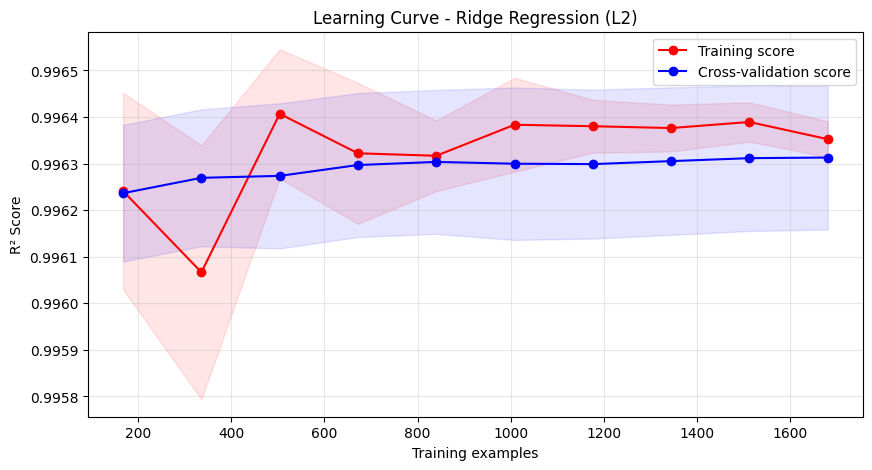

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve, learning_curve, train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# --------------------------
# Generate synthetic house price dataset
# --------------------------
np.random.seed(42)
n_samples = 3000

size_sqft = np.random.normal(2000, 500, n_samples)
size_sqft = np.clip(size_sqft, 800, 4000)
num_bedrooms = np.random.choice([2, 3, 4, 5], n_samples, p=[0.2, 0.4, 0.3, 0.1])
num_bathrooms = np.random.choice([1, 2, 3, 4], n_samples, p=[0.1, 0.5, 0.3, 0.1])
age_years = np.random.uniform(0, 50, n_samples)
location_score = np.random.uniform(1, 10, n_samples)

# Target variable (house price) with small noise
price_usd = (
    size_sqft * 150 +
    num_bedrooms * 15000 +
    num_bathrooms * 10000 +
    (50 - age_years) * 2000 +
    location_score * 8000 +
    np.random.normal(0, 5000, n_samples)  # smaller noise for RMSE ~ low
)
price_usd = np.clip(price_usd, 100000, 800000)

data = pd.DataFrame({
    'size_sqft': size_sqft,
    'num_bedrooms': num_bedrooms,
    'num_bathrooms': num_bathrooms,
    'age_years': age_years,
    'location_score': location_score,
    'price_usd': price_usd
})

# --------------------------
# Prepare train-test split
# --------------------------
X = data.drop('price_usd', axis=1)
y = data['price_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------
# Ridge Regression with cross-validation for alpha (L2 regularization)
# --------------------------
ridge_cv = RidgeCV(alphas=np.logspace(-4, 4, 50), cv=5)
ridge_cv.fit(X_train_scaled, y_train)

ridge_model = Ridge(alpha=ridge_cv.alpha_)
ridge_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = ridge_model.predict(X_train_scaled)
y_test_pred = ridge_model.predict(X_test_scaled)

# Performance metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)

print(f"Ridge Regression Results (L2):")
print(f"Optimal alpha: {ridge_cv.alpha_:.4f}")
print(f"Training R²: {train_r2:.4f}, RMSE: {train_rmse:.2f}")
print(f"Test R²: {test_r2:.4f}, RMSE: {test_rmse:.2f}, MAE: {mae:.2f}")

# Overfit/Underfit analysis
gap = train_r2 - test_r2
if gap <= 0.05:
    fit_status = "✓ Best Fit / Well-Generalized"
elif gap <= 0.12:
    fit_status = "⚠ Moderate Overfitting"
else:
    fit_status = "✗ High Overfitting"
print(f"Fit Status: {fit_status}")

# --------------------------
# Coefficients
# --------------------------
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge_model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)
print("\nTop Feature Coefficients:")
print(coef_df)

# --------------------------
# Learning Curve
# --------------------------
train_sizes, train_scores_lc, test_scores_lc = learning_curve(
    ridge_model, X_train_scaled, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='r2', n_jobs=-1
)
train_mean = np.mean(train_scores_lc, axis=1)
train_std = np.std(train_scores_lc, axis=1)
test_mean = np.mean(test_scores_lc, axis=1)
test_std = np.std(test_scores_lc, axis=1)

plt.figure(figsize=(10,5))
plt.plot(train_sizes, train_mean, 'o-', color='red', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='blue', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='red')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='blue')
plt.xlabel("Training examples")
plt.ylabel("R² Score")
plt.title("Learning Curve - Ridge Regression (L2)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


<h1>Results Anysis and Interpretation</h1>

In [13]:
import pandas as pd

# Get predictions for the test set
test_predictions = final_model.predict(X_test)

# Combine input features, actual prices, and predicted prices into a single DataFrame
results = X_test.copy()
results['Actual Price'] = y_test.values
results['Predicted Price'] = test_predictions

# Display the first few rows of the results
print("Full DataFrame with Input Features, Actual Prices, and Predicted Prices:")
print(results.head().to_string(index=False))

Full DataFrame with Input Features, Actual Prices, and Predicted Prices:
  size_sqft  num_bedrooms  num_bathrooms  age_years  location_score  Actual Price  Predicted Price
1969.669593             4              2  40.281846        3.445647 422045.521883    427417.171865
2052.687753             3              2  42.460957        2.704130 411502.843393    419051.762548
1640.423340             2              2   6.982117        5.434740 420193.103689    432694.355204
2458.930974             3              2  20.492384        6.212980 546903.877631    533955.607042
1587.294735             3              3  47.934533        9.381023 391271.102608    388990.244159


<h1>Model Saving </h1>

In [7]:
import joblib

# Save the trained model to a file
model_filename = "model/final_random_forest_model.pkl"
joblib.dump(final_model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to model/final_random_forest_model.pkl


<h1>Load Model</h1>

In [8]:
import joblib

# Load the trained model from the file
model_filename = "model/final_random_forest_model.pkl"
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model/final_random_forest_model.pkl


<h1>Prediction</h1>

In [9]:
import numpy as np
import pandas as pd

# Example new data for prediction
new_data = pd.DataFrame({
    'size_sqft': [1500, 2500],
    'num_bedrooms': [3, 4],
    'num_bathrooms': [2, 3],
    'age_years': [10, 5],
    'location_score': [8, 9]
})

# Make predictions using the loaded model
new_predictions = loaded_model.predict(new_data)

# Display predictions
for i, price in enumerate(new_predictions):
    print(f"Prediction for house {i + 1}: ${price:,.2f}")

Prediction for house 1: $440,468.03
Prediction for house 2: $632,111.57


<h1>Evaluation on the new data sample/inputs</h1>

In [10]:
import numpy as np
import pandas as pd

# Example new data for prediction
new_data = pd.DataFrame({
    'size_sqft': [1500, 2500],
    'num_bedrooms': [3, 4],
    'num_bathrooms': [2, 3],
    'age_years': [10, 5],
    'location_score': [8, 9]
})

# Make predictions using the loaded model
new_predictions = loaded_model.predict(new_data)

# Add predictions as a new column
new_data['Predicted Price (USD)'] = new_predictions.round(2)

# Display neatly
print("\nInput Data with Predicted Prices:")
print(new_data.to_string(index=False))



Input Data with Predicted Prices:
 size_sqft  num_bedrooms  num_bathrooms  age_years  location_score  Predicted Price (USD)
      1500             3              2         10               8              440468.03
      2500             4              3          5               9              632111.57


<h1>Results Analysis from a Saved Model</h1>

In [11]:
import pandas as pd

# Get predictions for the test set
test_predictions = loaded_model.predict(X_test)

# Combine input features, actual prices, and predicted prices into a single DataFrame
results = X_test.copy()
results['Actual Price'] = y_test.values
results['Predicted Price'] = test_predictions

# Display the first few rows of the results
print("Full DataFrame with Input Features, Actual Prices, and Predicted Prices:")
print(results.head().to_string(index=False))

Full DataFrame with Input Features, Actual Prices, and Predicted Prices:
  size_sqft  num_bedrooms  num_bathrooms  age_years  location_score  Actual Price  Predicted Price
1969.669593             4              2  40.281846        3.445647 422045.521883    427417.171865
2052.687753             3              2  42.460957        2.704130 411502.843393    419051.762548
1640.423340             2              2   6.982117        5.434740 420193.103689    432694.355204
2458.930974             3              2  20.492384        6.212980 546903.877631    533955.607042
1587.294735             3              3  47.934533        9.381023 391271.102608    388990.244159


<h1>Save a Ridge Model</h1>

In [14]:
import joblib

# --------------------------
# Save model and scaler
# --------------------------
joblib.dump(ridge_model, "model/ridge_model_l2.pkl")
joblib.dump(scaler, "model/scaler.pkl")

print("✅ Ridge model and scaler saved successfully!")

# --------------------------
# Load model and scaler (example)
# --------------------------
loaded_model = joblib.load("model/ridge_model_l2.pkl")
loaded_scaler = joblib.load("model/scaler.pkl")

# Example prediction with loaded model
X_test_scaled_loaded = loaded_scaler.transform(X_test)
y_test_pred_loaded = loaded_model.predict(X_test_scaled_loaded)
print(f"\nPrediction check (first 5 values): {y_test_pred_loaded[:5]}")


✅ Ridge model and scaler saved successfully!

Prediction check (first 5 values): [422468.56688473 409885.72823741 426120.91604328 542685.59952818
 392472.74282437]


<h1>Results Evaluation and Interpretation for Ridge Regression</h1>

In [22]:
import pandas as pd

# Scale X_test
X_test_scaled = scaler.transform(X_test)

# Make predictions
y_pred = ridge_model.predict(X_test_scaled)

# Combine X_test, actual y, and predicted y into one DataFrame
comparison_df = X_test.copy()
comparison_df['Actual_Price'] = y_test.values
comparison_df['Predicted_Price'] = y_pred


print(comparison_df.head().to_string(index=True))

        size_sqft  num_bedrooms  num_bathrooms  age_years  location_score   Actual_Price  Predicted_Price
1801  1969.669593             4              2  40.281846        3.445647  422045.521883    422468.566885
1190  2052.687753             3              2  42.460957        2.704130  411502.843393    409885.728237
1817  1640.423340             2              2   6.982117        5.434740  420193.103689    426120.916043
251   2458.930974             3              2  20.492384        6.212980  546903.877631    542685.599528
2505  1587.294735             3              3  47.934533        9.381023  391271.102608    392472.742824
